## 5 Classification models

To capture the realtionship between twitter sentiments and crypto prices, classification models are built to predict the directional change in crypto prices enough to make important decisions to sell or buy the currencies.

This script covers all the models along with cross correlation analysis performed to udnerstand the time lagged relationships.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
#features selection and class imbalance
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import PolynomialCountSketch
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
#machine learning models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
#model performance evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

### 5.1 Cross Correlation Analysis

In [2]:
summarised_all = pd.read_csv('input_model_file.csv')
summarised_all=summarised_all.drop(columns='Unnamed: 0')

summarised_all.head()

,Date,avg_neg_scr,avg_neu_scr,avg_pos_scr,avg_cmp_scr,avg_retweet_cnt,avg_like_cnt,tweet_vol,uniq_tweet_vol,avg_tweet_len,...,Negative_share,Open_prices,High_prices,Low_prices,Close_prices,Volume_BTC,polarity,pct_change,direction,Close
0,2021-07-01,0.021007,0.877197,0.101582,0.220600,2096.803213,1.747746,121675,54104,122.808901,...,0.075546,34595.875,34773.445,32711.785,33248.825,1.784648e+08,0.046195,NaN,NaN,63.50
1,2021-07-02,0.016984,0.889221,0.093512,0.210509,2542.598358,1.644665,109249,45549,124.999753,...,0.067506,33235.275,33953.980,32700.025,33676.020,1.148738e+08,0.039852,0.012848,1.0,63.51
2,2021-07-03,0.015089,0.886210,0.098290,0.215499,5788.559491,1.976620,126263,44563,122.904485,...,0.066385,33675.470,34951.140,33399.860,34679.150,6.563334e+07,0.038510,0.029788,1.0,63.51
3,2021-07-04,0.014355,0.873028,0.112238,0.257782,3349.956329,1.801355,108334,40391,122.499575,...,0.060230,34671.040,35972.855,34307.790,34825.025,7.937801e+07,0.040139,0.004206,1.0,63.51
4,2021-07-05,0.016379,0.870216,0.112665,0.259466,2227.247343,1.701465,120897,50291,124.201949,...,0.070754,34807.920,34909.210,33121.500,33823.215,1.209090e+08,0.042958,-0.028767,0.0,63.51


To understand which method to use in correlation analysis, normality test is performed

In [3]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro

col_list =['avg_neg_scr', 'avg_neu_scr', 'avg_pos_scr', 'avg_cmp_scr',
       'avg_retweet_cnt', 'avg_like_cnt', 'tweet_vol', 'uniq_tweet_vol',
       'avg_tweet_len', 'avg_followers_cnt', 'negative', 'neutral', 'positive',
       'Bullish_Ratio', 'Negative_share', 'Open_prices', 'High_prices',
       'Low_prices', 'Close_prices', 'Volume_BTC', 'polarity','Close'] 

for metric_name in col_list:
    stat, p = shapiro(summarised_all[metric_name])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print(metric_name + ' looks Gaussian (fail to reject H0)')
    else:
        print(metric_name + ' does not look Gaussian (reject H0)')

Statistics=0.850, p=0.000
avg_neg_scr does not look Gaussian (reject H0)
Statistics=0.975, p=0.417
avg_neu_scr looks Gaussian (fail to reject H0)
Statistics=0.995, p=0.999
avg_pos_scr looks Gaussian (fail to reject H0)
Statistics=0.976, p=0.451
avg_cmp_scr looks Gaussian (fail to reject H0)
Statistics=0.886, p=0.000
avg_retweet_cnt does not look Gaussian (reject H0)
Statistics=0.922, p=0.004
avg_like_cnt does not look Gaussian (reject H0)
Statistics=0.915, p=0.003
tweet_vol does not look Gaussian (reject H0)
Statistics=0.913, p=0.002
uniq_tweet_vol does not look Gaussian (reject H0)
Statistics=0.840, p=0.000
avg_tweet_len does not look Gaussian (reject H0)
Statistics=0.972, p=0.326
avg_followers_cnt looks Gaussian (fail to reject H0)
Statistics=0.860, p=0.000
negative does not look Gaussian (reject H0)
Statistics=0.928, p=0.007
neutral does not look Gaussian (reject H0)
Statistics=0.923, p=0.005
positive does not look Gaussian (reject H0)
Statistics=0.974, p=0.389
Bullish_Ratio looks G

**Since most series is non-normal we will use kendall method for calculating correlations**

In [4]:
#Function to calculate pairwise correlation
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    #print( datax.corr(datay.shift(lag), method=method))
    return datax.corr(datay.shift(lag), method=method)

In [5]:
col_list =['avg_neg_scr', 'avg_neu_scr', 'avg_pos_scr', 'avg_cmp_scr',
       'avg_retweet_cnt', 'avg_like_cnt', 'tweet_vol', 'uniq_tweet_vol',
       'avg_tweet_len', 'avg_followers_cnt', 'negative', 'neutral', 'positive',
       'Bullish_Ratio', 'Negative_share', 'Open_prices', 'High_prices',
       'Low_prices', 'Close_prices', 'Volume_BTC', 'polarity','Close']
corr = dict()
for metric_name in col_list:
    for i in range(0,3):
        metric = metric_name+'_L'+ str(i)
        corr[metric] = crosscorr(summarised_all['direction'],summarised_all[metric_name], lag=i, method="kendall")

In [6]:
df = pd.DataFrame.from_dict(corr, orient ='index') 
df = df.reset_index()
df = df.rename(columns={'index' :'variables',0:'correlation_score'})
df = df.sort_values(by='correlation_score', ascending = False)

In [8]:
import plotly.express as px
fig = px.bar(df, x='variables', y='correlation_score')
fig.show()

It is evident that open crypto prices, sentiment score and tweet attributes like length has almost insignificant correlation with direction variable at lag 0

In [9]:
df[(df['correlation_score']>=0.15) | (df['correlation_score']<=-0.10)]

,variables,correlation_score
61,polarity_L1,0.283129
59,Volume_BTC_L2,0.264047
7,avg_pos_scr_L1,0.257390
17,avg_like_cnt_L2,0.225260
36,positive_L0,0.220211
62,polarity_L2,0.216310
12,avg_retweet_cnt_L0,0.208772
37,positive_L1,0.205912
54,Close_prices_L0,0.197332
58,Volume_BTC_L1,0.194472


In [8]:
df[(df['correlation_score']>=0.15) | (df['correlation_score']<=-0.10)]['variables'].values.tolist()


['polarity_L1',
 'Volume_BTC_L2',
 'avg_pos_scr_L1',
 'avg_like_cnt_L2',
 'positive_L0',
 'polarity_L2',
 'avg_retweet_cnt_L0',
 'positive_L1',
 'Close_prices_L0',
 'Volume_BTC_L1',
 'negative_L2',
 'avg_followers_cnt_L2',
 'avg_neg_scr_L2',
 'avg_cmp_scr_L1',
 'Volume_BTC_L0',
 'tweet_vol_L0',
 'uniq_tweet_vol_L2',
 'positive_L2',
 'negative_L1',
 'avg_like_cnt_L0',
 'avg_neu_scr_L2',
 'Negative_share_L0',
 'Close_L2',
 'avg_neu_scr_L1']

### 5.2 Models with tweet data

In [9]:
summarised_all.columns

Index(['Date', 'avg_neg_scr', 'avg_neu_scr', 'avg_pos_scr', 'avg_cmp_scr',
       'avg_retweet_cnt', 'avg_like_cnt', 'tweet_vol', 'uniq_tweet_vol',
       'avg_tweet_len', 'avg_followers_cnt', 'negative', 'neutral', 'positive',
       'Bullish_Ratio', 'Negative_share', 'Open_prices', 'High_prices',
       'Low_prices', 'Close_prices', 'Volume_BTC', 'polarity', 'pct_change',
       'direction', 'Close'],
      dtype='object')

In [10]:
model_data = summarised_all[summarised_all['Date']>='2021-07-01'].set_index('Date')

df_shift_1 = model_data.shift(1).add_suffix('_L1')
df_shift_2 = model_data.shift(2).add_suffix('_L2')
model_data2 = model_data.add_suffix('_L0').merge(df_shift_1,on='Date', how='left')
model_data2 = model_data2.merge(df_shift_2,on='Date', how='left')

model_data = model_data2[['polarity_L1',
 'avg_pos_scr_L1',
 'avg_like_cnt_L2',
 'positive_L0',
 'polarity_L2',
 'avg_retweet_cnt_L0',
 'positive_L1',
 'negative_L2',
 'avg_followers_cnt_L2',
 'avg_neg_scr_L2',
 'avg_cmp_scr_L1',
 'tweet_vol_L0',
 'uniq_tweet_vol_L2',
 'positive_L2',
 'negative_L1',
 'avg_like_cnt_L0',
 'avg_neu_scr_L2',
 'Negative_share_L0',
 'avg_neu_scr_L1',
'direction_L0']]

model_data.head()
 

,polarity_L1,avg_pos_scr_L1,avg_like_cnt_L2,positive_L0,polarity_L2,avg_retweet_cnt_L0,positive_L1,negative_L2,avg_followers_cnt_L2,avg_neg_scr_L2,avg_cmp_scr_L1,tweet_vol_L0,uniq_tweet_vol_L2,positive_L2,negative_L1,avg_like_cnt_L0,avg_neu_scr_L2,Negative_share_L0,avg_neu_scr_L1,direction_L0
Date,,,,,,,,,,,,,,,,,,,,
2021-07-01,NaN,NaN,NaN,52226,NaN,2096.803213,NaN,NaN,NaN,NaN,NaN,121675,NaN,NaN,NaN,1.747746,NaN,0.075546,NaN,NaN
2021-07-02,0.046195,0.101582,NaN,46556,NaN,2542.598358,52226.0,NaN,NaN,NaN,0.220600,109249,NaN,NaN,9192.0,1.644665,NaN,0.067506,0.877197,1.0
2021-07-03,0.039852,0.093512,1.747746,55244,0.046195,5788.559491,46556.0,9192.0,2179.789094,0.021007,0.210509,126263,54104.0,52226.0,7375.0,1.976620,0.877197,0.066385,0.889221,1.0
2021-07-04,0.038510,0.098290,1.644665,55071,0.039852,3349.956329,55244.0,7375.0,2010.086582,0.016984,0.215499,108334,45549.0,46556.0,8382.0,1.801355,0.889221,0.060230,0.886210,1.0
2021-07-05,0.040139,0.112238,1.976620,60639,0.038510,2227.247343,55071.0,8382.0,1688.782803,0.015089,0.257782,120897,44563.0,55244.0,6525.0,1.701465,0.886210,0.070754,0.873028,0.0


In [11]:
model_data = model_data.dropna()
model_data.head()

,polarity_L1,avg_pos_scr_L1,avg_like_cnt_L2,positive_L0,polarity_L2,avg_retweet_cnt_L0,positive_L1,negative_L2,avg_followers_cnt_L2,avg_neg_scr_L2,avg_cmp_scr_L1,tweet_vol_L0,uniq_tweet_vol_L2,positive_L2,negative_L1,avg_like_cnt_L0,avg_neu_scr_L2,Negative_share_L0,avg_neu_scr_L1,direction_L0
Date,,,,,,,,,,,,,,,,,,,,
2021-07-03,0.039852,0.093512,1.747746,55244,0.046195,5788.559491,46556.0,9192.0,2179.789094,0.021007,0.210509,126263,54104.0,52226.0,7375.0,1.976620,0.877197,0.066385,0.889221,1.0
2021-07-04,0.038510,0.098290,1.644665,55071,0.039852,3349.956329,55244.0,7375.0,2010.086582,0.016984,0.215499,108334,45549.0,46556.0,8382.0,1.801355,0.889221,0.060230,0.886210,1.0
2021-07-05,0.040139,0.112238,1.976620,60639,0.038510,2227.247343,55071.0,8382.0,1688.782803,0.015089,0.257782,120897,44563.0,55244.0,6525.0,1.701465,0.886210,0.070754,0.873028,0.0
2021-07-06,0.042958,0.112665,1.801355,66354,0.040139,2098.188073,60639.0,6525.0,1777.710857,0.014355,0.259466,123314,40391.0,55071.0,8554.0,1.974374,0.873028,0.088384,0.870216,1.0
2021-07-07,0.045953,0.115642,1.701465,46998,0.042958,2605.157232,66354.0,8554.0,1873.034095,0.016379,0.270794,110175,50291.0,60639.0,10899.0,1.723612,0.870216,0.061339,0.865466,0.0


### Test and train split

Input data is split into taining and test in 70:30 ratio.

In [12]:
## Splitting 70/30
index = round(len(model_data['direction_L0'])*.70)

train =  model_data.iloc[:index]
test =  model_data.iloc[index:]

X=model_data.drop(columns=['direction_L0'])
y=model_data[['direction_L0']]


In [13]:
X_train = train.drop(columns=['direction_L0'])
X_test = test.drop(columns=['direction_L0'])
Y_train = train[['direction_L0']]
Y_test = test[['direction_L0']]

In [14]:
print('train:'+ str(train.shape))
print('test:'+ str(test.shape))
print('X:'+ str(X.shape))
print('y:'+ str(y.shape))
print('X_train:'+ str(X_train.shape))
print('X_test:'+ str(X_test.shape))
print('Y_train:'+ str(Y_train.shape))
print('Y_test:'+ str(Y_test.shape))

train:(31, 20)
test:(13, 20)
X:(44, 19)
y:(44, 1)
X_train:(31, 19)
X_test:(13, 19)
Y_train:(31, 1)
Y_test:(13, 1)


<AxesSubplot:xlabel='direction_L0', ylabel='count'>

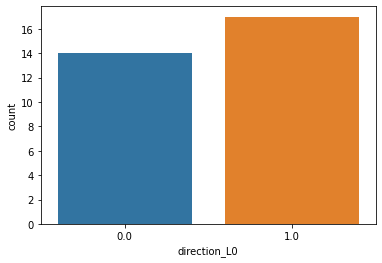

In [15]:
sns.countplot(x = "direction_L0", data=train)

### 1. Logistic Regression

Logistic Regression is a discriminative classifier that uses a linear regression model to represent the probability through a logistic function in matrix notation: 
\begin{equation}
p(X) = \frac{exp(w^Tx)}{1+exp(w^Tx)}
\end{equation}
where $w^T$ represents the matrix for coefficients for each feature and x represents the observations. 

Logistic regression is popular machine learning method for binary classification. While simple, it gives good accuracy and has low training time. Additionally, it outputs a probability of the event being classified as class 0 or 1, which can then be adjusted using different threshold values depending on our classification purpose. For example, if the cost of misclassifying class 1 is too high, we would want to have a higher recall rate for class 1, thus we can do so by increasing the threshold value for the model to classify obsevation as class 1.  

In [16]:
#Fit Logistic Regression on new dataset
params = {"C": [0.00001,0.0001,0.001,0.01,0.1, 1, 10, 100, 500, 1000],
    "penalty": ["l2", "l1", "elasticnet", "none"]}
model = LogisticRegression(solver ='saga', random_state=0) #saga supports all penalty and faster for large dataset
logreg = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
logreg.fit(X_train, Y_train.values.ravel())
logreg.best_estimator_

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [0.5        0.61111111        nan 0.5        0.5        0.47777778
        nan 0.5        0.5        0.5               nan 0.5
 0.5        0.5               nan 0.5        0.5        0.5
        nan 0.5        0.5        0.5               nan 0.5
 0.5        0.5               nan 0.5        0.5        0.5
        nan 0.5        0.5        0.5               nan 0.5
 0.5        0.5               nan 0.5       ]

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LogisticRegression(C=1e-05, penalty='l1', random_state=0, solver='saga')

In [17]:
#make predictions using LR model
y_pred = logreg.predict(X_test)

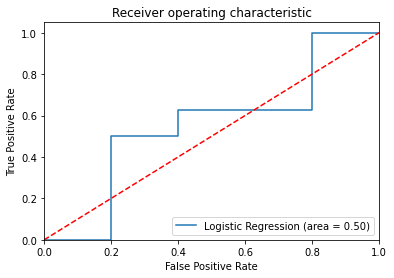

In [18]:
#Create ROC curve
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [19]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.609957884541093


In [20]:
#results based on optimal threshold
THRESHOLD = optimal_threshold
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

tn, fp, fn, tp = confusion_matrix(Y_test, preds).ravel()
(tn, fp, fn, tp)

(4, 1, 5, 3)

In [21]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

         0.0       0.44      0.80      0.57         5
         1.0       0.75      0.38      0.50         8

    accuracy                           0.54        13
   macro avg       0.60      0.59      0.54        13
weighted avg       0.63      0.54      0.53        13



**Result - Logistic Regression Classifier is a weak classifier with very poor accuracy of 54%**

### 2. XGBoost: an example of Boosting algorithm

Next, we tried a gradiant boosting machine learning method called XGBoost (extreme Gradient Boosting), which is an implementation of gradiant boosted decision trees. Boosting is an ensemble method, where models are added consecutively to improve accuracy of the previous ones, and gradient boosting uses gradient descent algorithm to minimise the loss when adding new models. 

XGBoost is popular as it provides results with high accuracy in both classification and regression problems. Before implementing XGBoost, we will tune 4 of its parameters:
1. *n_estimators*: number of estimators when boosting is terminated. 
2. *max_depth*: maximum depth of a tree. Higher value can make the tree overfit
3. *gamma*: minimum loss reduction required to make partition on a leaf node of the tree. the higher value of gamma, the more conservative the algorithm will be
4. *scale_pos_weight*: parameter that control the balance for positive and negative weights. Since our data is slightly imbalance, we will tune a few values to see if it makes a big difference to our results

To tune these parameters, we will use *GridSearchCV()* which performs exhaustive search over specified parameter values for a model. It works by cross-validating grid-search over parameter grid.

In [22]:
#tuning number of estimators
param_test = {'n_estimators': range(1,100,4)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', learning_rate=0.2, use_label_encoder =False, eval_metric = 'auc'), 
                   param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=5)
gsearch1.fit(X_train, Y_train)
gsearch1.best_params_

{'n_estimators': 1}

In [23]:
#tuning maximum tree depth
param_test2 = {'max_depth':range(1,10,2)}
gsearch2 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc'), 
                        param_grid = param_test2, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch2.fit(X_train, Y_train)
gsearch2.best_params_

{'max_depth': 3}

In [24]:
#tuning gamma parameter
param_test3 = {'gamma': [i/10.0 for i in range(0,5)]} 
gsearch3 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc',
                                                 max_depth = gsearch2.best_params_['max_depth']), 
                                                 param_grid = param_test3, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch3.fit(X_train, Y_train)
gsearch3.best_params_

{'gamma': 0.0}

In [25]:
#tuning scale_pos_weight because data is imbalanced
param_test4 = {'scale_pos_weight': range(1,10,2)} ## Imbalance ratio of approx 1 to 1.14, so we iterate through a few weights
gsearch4 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc',
                                                 max_depth = gsearch2.best_params_['max_depth'], gamma = gsearch3.best_params_['gamma']),
                                                 param_grid = param_test4, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch4.fit(X_train, Y_train)
gsearch4.best_params_

{'scale_pos_weight': 3}

We will fit the final model using the optimised parameters we have found above.

In [26]:
#Final model
XGB_model = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], max_depth = gsearch2.best_params_['max_depth'],
                    gamma = gsearch3.best_params_['gamma'], scale_pos_weight = gsearch4.best_params_['scale_pos_weight'], n_jobs=-1, learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc')

XGB_model.fit(X_train, Y_train.values.ravel())
XGB_model_predict = XGB_model.predict(X_test)

C:\Users\saggarwal\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [27]:
XGB_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [28]:
print(classification_report(Y_test, XGB_model_predict))
tn, fp, fn, tp = confusion_matrix(Y_test, XGB_model_predict).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.45      1.00      0.62         5
         1.0       1.00      0.25      0.40         8

    accuracy                           0.54        13
   macro avg       0.73      0.62      0.51        13
weighted avg       0.79      0.54      0.49        13

(5, 0, 6, 2) 



**Result - XgBoost is equally a poor classifier with accuracy of 54%**

### 3. SVM Model

Here, we tried a non-probabilistic classifier called Support Vector Machine (SVM). This method is effective in high dimensional space and can control overfitting using its regularisation term. Additionally, it can use different kernel tricks, like polynomial or radial basis function, to transform non-linear problems to linearly separable cases. 

*SVC()* from sklearn.svm package only works well for dataset with tens of thousands observations. We will also try *SGDClassifier()* or *LinearSVC()* with different tuning parameters. Here, we will also explore different kernel approximations: linear, Radial Basis Function, and polynomial.

We will tune 3 parameters: 
1. *loss*: the loss function to be used for classification
2. *alpha*: a constant that multiplies by the regularisation term 
3. *penalty*: the penalty or regularisation term 

**SVM using SVC and SGDClassifier() function**

In [29]:
from sklearn import svm
scaler = StandardScaler()
SVM_Xtrain = scaler.fit_transform(X_train)
SVM_Xtest = scaler.transform(X_test)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [0.0001,0.001, 0.01, 0.1,1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.0001,0.001, 0.01, 0.1,1, 10, 100, 1000]}]
#model = svm.SVC(kernel='linear')
clf = GridSearchCV(svm.SVC(), param_grid=tuned_parameters, n_jobs=-1, cv=5,
                  scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

SVC(C=0.0001, gamma=0.001)


In [30]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.62      1.00      0.76         8

    accuracy                           0.62        13
   macro avg       0.31      0.50      0.38        13
weighted avg       0.38      0.62      0.47        13

(0, 5, 0, 8) 



C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



a. SVM as Linear classifier

In [31]:
scaler = StandardScaler()
SVM_Xtrain = scaler.fit_transform(X_train)
SVM_Xtest = scaler.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = SGDClassifier(max_iter=100, random_state=0)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5,
                  scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

SGDClassifier(alpha=0.1, loss='log', max_iter=100, penalty='elasticnet',
              random_state=0)


In [32]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.40      0.40      0.40         5
         1.0       0.62      0.62      0.62         8

    accuracy                           0.54        13
   macro avg       0.51      0.51      0.51        13
weighted avg       0.54      0.54      0.54        13

(2, 3, 3, 5) 



b. SVM using Radial Basis Function Kernel

In [33]:
params = {'gamma': [1, 0.1, 0.01, 0.001]}
rbf_feature = GridSearchCV(RBFSampler(), param_grid = params, n_jobs=-1, cv=5, scoring='explained_variance')
rbf_feature.fit(X_train)
SVM_Xtrain = rbf_feature.transform(X_train)
SVM_Xtest = rbf_feature.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = SGDClassifier(max_iter=100, random_state=0)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5,
                  scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan]



SGDClassifier(alpha=0.01, max_iter=100, penalty='l1', random_state=0)


In [34]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.33      0.40      0.36         5
         1.0       0.57      0.50      0.53         8

    accuracy                           0.46        13
   macro avg       0.45      0.45      0.45        13
weighted avg       0.48      0.46      0.47        13

(2, 3, 4, 4) 



c. SVM using Polynomial Kernel

In [35]:
poly_feature = PolynomialCountSketch(degree = 2, n_components = 200) #optimal n_components = 10*n_features
SVM_Xtrain = poly_feature.fit_transform(X_train)
SVM_Xtest = poly_feature.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = SGDClassifier(max_iter=100, random_state=0)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5,
                  scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

SGDClassifier(alpha=0.01, loss='log', max_iter=100, random_state=0)


In [36]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.38      1.00      0.56         5
         1.0       0.00      0.00      0.00         8

    accuracy                           0.38        13
   macro avg       0.19      0.50      0.28        13
weighted avg       0.15      0.38      0.21        13

(5, 0, 8, 0) 



C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



**SVM using LinearSVC() function**

As SVM with the radial basis function and polynomial kernel did not give good results as observed earlier when implementing with *SGDClassifier()*, we will try to implement here - linear and polynomial kernel instead.

a. SVM as Linear Classifier

In [37]:
scaler = StandardScaler()
SVM_Xtrain = scaler.fit_transform(X_train)
SVM_Xtest = scaler.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "C": [0.0001, 0.001, 0.01,0.1, 1, 10, 100, 500, 1000],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = LinearSVC(dual=False, random_state=0)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

LinearSVC(C=0.001, dual=False, random_state=0)


C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.75833333 0.5               nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.78333333 0.5               nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.77777778 0.5               nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.59722222 0.58333333        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.68333333 0.59444444        nan        nan        nan        nan
        nan        nan        nan        nan    

In [38]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.67      0.40      0.50         5
         1.0       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13

(2, 3, 1, 7) 



b. SVM using Polynomial Kernel

In [39]:
poly_feature = PolynomialCountSketch(degree = 2, n_components = 180) #optimal n_components = 10*n_features
SVM_Xtrain = poly_feature.fit_transform(X_train)
SVM_Xtest = poly_feature.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "C": [0.1, 1, 10, 100, 500, 1000],
    "penalty": ["l2", "l1", "elasticnet"],
    "max_iter": [10000]
}
model = LinearSVC(dual=False, random_state=0)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

LinearSVC(C=0.1, dual=False, max_iter=10000, penalty='l1', random_state=0)


C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.56111111 0.72222222        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.51666667 0.71944444        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.53888889 0.72222222        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.56111111 0.69722222        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.51666667 0.69722222        nan        nan        nan        nan
        nan        nan        nan        nan    

In [40]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         5
         1.0       1.00      0.38      0.55         8

    accuracy                           0.62        13
   macro avg       0.75      0.69      0.61        13
weighted avg       0.81      0.62      0.59        13

(5, 0, 5, 3) 



**Result - Out of all the SVM classifiers, LinearSVC() has the highest accuracy of 69%**

### 4. Random Forest

Random Forest is a ensemble method called bagging, where it constructs multiple trees using random features on a sub-set of data while training and the average prediction of individual trees is returned. It is superior to decision trees as it can control overfitting and improve predictive accuracy. It also works well on large dataset.

To implement Random Forest, we will tune 2 of its parameters: 
1. *n_estimators*: number of tress in the forest  
2. *max_features*: number of features to consider when looking for the best split

### Random Forest - Hyper parameter tuning using GridSearchCV

In [41]:
params = {'n_estimators': range(1, 200, 20),
         'max_features': ['auto', 'log2']}
model = RandomForestClassifier(n_jobs=-1, random_state=0)
rfc = GridSearchCV(model, param_grid = params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
rfc.fit(X_train, Y_train.values.ravel())
print(rfc.best_estimator_) 

RandomForestClassifier(n_estimators=41, n_jobs=-1, random_state=0)


In [42]:
y_preds = rfc.predict(X_test)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77         5
         1.0       1.00      0.62      0.77         8

    accuracy                           0.77        13
   macro avg       0.81      0.81      0.77        13
weighted avg       0.86      0.77      0.77        13

(5, 0, 3, 5) 



<BarContainer object of 19 artists>

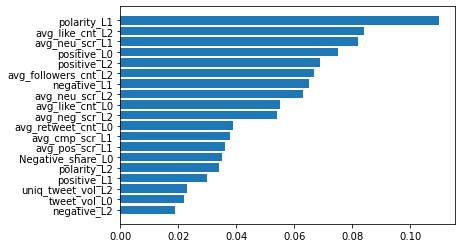

In [43]:
#Feature importance refers to techniques that assign a score to input features based on 
#how useful they are at predicting a target variable.
importances_ML = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rfc.best_estimator_.feature_importances_,3)})
importances_ML = importances_ML.sort_values('importance',ascending=True)
ml = importances_ML.loc[importances_ML['importance'] > 0]
ml.sort_values('importance', inplace=True)
plt.barh(ml['feature'], ml['importance'])

### Random Forest - Hyper parameter tuning using RandomisedSearchCV

In [44]:
rfc = RandomForestClassifier()
rfc.fit(X_train,Y_train.values.ravel())
# predictions
rfc_predict = rfc.predict(X_test)

In [45]:
rfc_cv_score = cross_val_score(rfc, X, y.values.ravel(), cv=10, scoring='roc_auc')

In [46]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(Y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[4 1]
 [4 4]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.50      0.80      0.62         5
         1.0       0.80      0.50      0.62         8

    accuracy                           0.62        13
   macro avg       0.65      0.65      0.62        13
weighted avg       0.68      0.62      0.62        13



=== All AUC Scores ===
[0.16666667 0.16666667 0.16666667 0.83333333 1.         1.
 1.         0.5        0.5        0.75      ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6083333333333333


In [47]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, Y_train.values.ravel())
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 800, 'max_features': 'auto', 'max_depth': 380}


In [48]:
rfc = RandomForestClassifier(n_estimators=800, max_depth=380, max_features='auto', random_state=0)
rfc.fit(X_train,Y_train.values.ravel())
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y.values.ravel(), cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(Y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[5 0]
 [3 5]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77         5
         1.0       1.00      0.62      0.77         8

    accuracy                           0.77        13
   macro avg       0.81      0.81      0.77        13
weighted avg       0.86      0.77      0.77        13



=== All AUC Scores ===
[0.16666667 0.16666667 0.16666667 0.83333333 1.         1.
 1.         0.5        0.5        0.75      ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6083333333333333


**Results - Random Forest with hyper parameter tuning method gave the highest accuracy of 77%**

### 4. Neural Networks

Here, we tried Neural Networks method, which is superior at capturing complex relationships between varibles by searching through different models in its black box to find patterns. In its black box, there can be one or more linear or non-linear hidden layers. 

We need to normalise the data before running neural networks as it is sensitive to feature scaling. We also specify that it will train using 2 hidden layers as 1 or 2 should give a decent performance for most problems, and 20 as number of neurons as we have 20 features in our dataset. 

In [49]:
scaler = StandardScaler()
NN_Xtrain = scaler.fit_transform(X_train)
NN_Xtest = scaler.transform(X_test)

params = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
model = MLPClassifier(hidden_layer_sizes = (20, 20), max_iter = 100, solver='adam', random_state=0) 
#2 hidden layers and 'adam' optimizer works well for large dataset
mlp = GridSearchCV(model, param_grid = params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
mlp.fit(NN_Xtrain, Y_train.values.ravel())
print(mlp.best_estimator_) 

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(20, 20),
              max_iter=100, random_state=0)


C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



In [50]:
y_preds = mlp.predict(NN_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      0.88      0.70         8

    accuracy                           0.54        13
   macro avg       0.29      0.44      0.35        13
weighted avg       0.36      0.54      0.43        13

(0, 5, 1, 7) 



### 2. Models with twitter and Crypto data

In [9]:
summarised_all.columns

Index(['Date', 'avg_neg_scr', 'avg_neu_scr', 'avg_pos_scr', 'avg_cmp_scr',
       'avg_retweet_cnt', 'avg_like_cnt', 'tweet_vol', 'uniq_tweet_vol',
       'avg_tweet_len', 'avg_followers_cnt', 'negative', 'neutral', 'positive',
       'Bullish_Ratio', 'Negative_share', 'Open_prices', 'High_prices',
       'Low_prices', 'Close_prices', 'Volume_BTC', 'polarity', 'pct_change',
       'direction', 'Close'],
      dtype='object')

In [10]:
model_data = summarised_all[summarised_all['Date']>='2021-07-01'].set_index('Date')

df_shift_1 = model_data.shift(1).add_suffix('_L1')
df_shift_2 = model_data.shift(2).add_suffix('_L2')
model_data2 = model_data.add_suffix('_L0').merge(df_shift_1,on='Date', how='left')
model_data2 = model_data2.merge(df_shift_2,on='Date', how='left')

model_data = model_data2[['polarity_L1',
 'Volume_BTC_L2',
 'avg_pos_scr_L1',
 'avg_like_cnt_L2',
 'positive_L0',
 'polarity_L2',
 'avg_retweet_cnt_L0',
 'positive_L1',
 'Close_prices_L0',
 'Volume_BTC_L1',
 'negative_L2',
 'avg_followers_cnt_L2',
 'avg_neg_scr_L2',
 'avg_cmp_scr_L1',
 'Volume_BTC_L0',
 'tweet_vol_L0',
 'uniq_tweet_vol_L2',
 'positive_L2',
 'negative_L1',
 'avg_like_cnt_L0',
 'avg_neu_scr_L2',
 'Negative_share_L0',
 'Close_L2',
 'avg_neu_scr_L1',
'direction_L0']]

model_data.head()
 

,polarity_L1,Volume_BTC_L2,avg_pos_scr_L1,avg_like_cnt_L2,positive_L0,polarity_L2,avg_retweet_cnt_L0,positive_L1,Close_prices_L0,Volume_BTC_L1,...,tweet_vol_L0,uniq_tweet_vol_L2,positive_L2,negative_L1,avg_like_cnt_L0,avg_neu_scr_L2,Negative_share_L0,Close_L2,avg_neu_scr_L1,direction_L0
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,NaN,NaN,NaN,NaN,52226,NaN,2096.803213,NaN,33248.825,NaN,...,121675,NaN,NaN,NaN,1.747746,NaN,0.075546,NaN,NaN,NaN
2021-07-02,0.046195,NaN,0.101582,NaN,46556,NaN,2542.598358,52226.0,33676.020,1.784648e+08,...,109249,NaN,NaN,9192.0,1.644665,NaN,0.067506,NaN,0.877197,1.0
2021-07-03,0.039852,1.784648e+08,0.093512,1.747746,55244,0.046195,5788.559491,46556.0,34679.150,1.148738e+08,...,126263,54104.0,52226.0,7375.0,1.976620,0.877197,0.066385,63.50,0.889221,1.0
2021-07-04,0.038510,1.148738e+08,0.098290,1.644665,55071,0.039852,3349.956329,55244.0,34825.025,6.563334e+07,...,108334,45549.0,46556.0,8382.0,1.801355,0.889221,0.060230,63.51,0.886210,1.0
2021-07-05,0.040139,6.563334e+07,0.112238,1.976620,60639,0.038510,2227.247343,55071.0,33823.215,7.937801e+07,...,120897,44563.0,55244.0,6525.0,1.701465,0.886210,0.070754,63.51,0.873028,0.0


In [11]:
model_data = model_data.dropna()
model_data.head()

,polarity_L1,Volume_BTC_L2,avg_pos_scr_L1,avg_like_cnt_L2,positive_L0,polarity_L2,avg_retweet_cnt_L0,positive_L1,Close_prices_L0,Volume_BTC_L1,...,tweet_vol_L0,uniq_tweet_vol_L2,positive_L2,negative_L1,avg_like_cnt_L0,avg_neu_scr_L2,Negative_share_L0,Close_L2,avg_neu_scr_L1,direction_L0
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-03,0.039852,1.784648e+08,0.093512,1.747746,55244,0.046195,5788.559491,46556.0,34679.150,1.148738e+08,...,126263,54104.0,52226.0,7375.0,1.976620,0.877197,0.066385,63.50,0.889221,1.0
2021-07-04,0.038510,1.148738e+08,0.098290,1.644665,55071,0.039852,3349.956329,55244.0,34825.025,6.563334e+07,...,108334,45549.0,46556.0,8382.0,1.801355,0.889221,0.060230,63.51,0.886210,1.0
2021-07-05,0.040139,6.563334e+07,0.112238,1.976620,60639,0.038510,2227.247343,55071.0,33823.215,7.937801e+07,...,120897,44563.0,55244.0,6525.0,1.701465,0.886210,0.070754,63.51,0.873028,0.0
2021-07-06,0.042958,7.937801e+07,0.112665,1.801355,66354,0.040139,2098.188073,60639.0,34354.720,1.209090e+08,...,123314,40391.0,55071.0,8554.0,1.974374,0.873028,0.088384,63.51,0.870216,1.0
2021-07-07,0.045953,1.209090e+08,0.115642,1.701465,46998,0.042958,2605.157232,66354.0,33609.735,1.520159e+08,...,110175,50291.0,60639.0,10899.0,1.723612,0.870216,0.061339,63.51,0.865466,0.0


### Test and train split

Input data is split into taining and test in 70:30 ratio.

In [12]:
## Splitting 70/30
index = round(len(model_data['direction_L0'])*.70)

train =  model_data.iloc[:index]
test =  model_data.iloc[index:]

X=model_data.drop(columns=['direction_L0'])
y=model_data[['direction_L0']]


In [13]:
X_train = train.drop(columns=['direction_L0'])
X_test = test.drop(columns=['direction_L0'])
Y_train = train[['direction_L0']]
Y_test = test[['direction_L0']]

In [14]:
print('train:'+ str(train.shape))
print('test:'+ str(test.shape))
print('X:'+ str(X.shape))
print('y:'+ str(y.shape))
print('X_train:'+ str(X_train.shape))
print('X_test:'+ str(X_test.shape))
print('Y_train:'+ str(Y_train.shape))
print('Y_test:'+ str(Y_test.shape))

train:(31, 25)
test:(13, 25)
X:(44, 24)
y:(44, 1)
X_train:(31, 24)
X_test:(13, 24)
Y_train:(31, 1)
Y_test:(13, 1)


<AxesSubplot:xlabel='direction_L0', ylabel='count'>

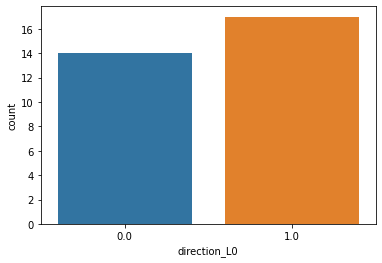

In [15]:
sns.countplot(x = "direction_L0", data=train)

### 1. Logistic Regression

Logistic Regression is a discriminative classifier that uses a linear regression model to represent the probability through a logistic function in matrix notation: 
\begin{equation}
p(X) = \frac{exp(w^Tx)}{1+exp(w^Tx)}
\end{equation}
where $w^T$ represents the matrix for coefficients for each feature and x represents the observations. 

Logistic regression is popular machine learning method for binary classification. While simple, it gives good accuracy and has low training time. Additionally, it outputs a probability of the event being classified as class 0 or 1, which can then be adjusted using different threshold values depending on our classification purpose. For example, if the cost of misclassifying class 1 is too high, we would want to have a higher recall rate for class 1, thus we can do so by increasing the threshold value for the model to classify obsevation as class 1.  

In [16]:
#Fit Logistic Regression on new dataset
params = {"C": [0.00001,0.0001,0.001,0.01,0.1, 1, 10, 100, 500, 1000],
    "penalty": ["l2", "l1", "elasticnet", "none"]}
model = LogisticRegression(solver ='saga', random_state=0) #saga supports all penalty and faster for large dataset
logreg = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
logreg.fit(X_train, Y_train.values.ravel())
logreg.best_estimator_

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [0.53611111 0.53611111        nan 0.53611111 0.53611111 0.53611111
        nan 0.53611111 0.53611111 0.53611111        nan 0.53611111
 0.53611111 0.53611111        nan 0.53611111 0.53611111 0.53611111
        nan 0.53611111 0.53611111 0.53611111        nan 0.53611111
 0.53611111 0.53611111        nan 0.53611111 0.53611111 0.53611111
        nan 0.53611111 0.53611111 0.53611111        nan 0.53611111
 0.53611111 0.53611111        nan 0.53611111]

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LogisticRegression(C=1e-05, random_state=0, solver='saga')

In [17]:
#make predictions using LR model
y_pred = logreg.predict(X_test)

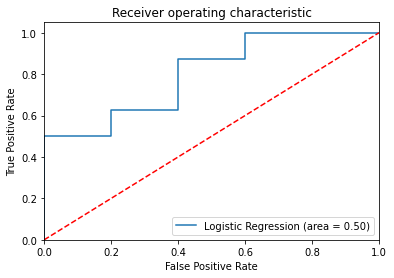

In [18]:
#Create ROC curve
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [19]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.732019269355021


In [20]:
#results based on optimal threshold
THRESHOLD = optimal_threshold
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

tn, fp, fn, tp = confusion_matrix(Y_test, preds).ravel()
(tn, fp, fn, tp)

(5, 0, 5, 3)

In [21]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         5
         1.0       1.00      0.38      0.55         8

    accuracy                           0.62        13
   macro avg       0.75      0.69      0.61        13
weighted avg       0.81      0.62      0.59        13



**Result - Logistic Regression Classifier performs better with crypto and dow rpices with an accuracy of 62%**

### 2. XGBoost: an example of Boosting algorithm

Next, we tried a gradiant boosting machine learning method called XGBoost (extreme Gradient Boosting), which is an implementation of gradiant boosted decision trees. Boosting is an ensemble method, where models are added consecutively to improve accuracy of the previous ones, and gradient boosting uses gradient descent algorithm to minimise the loss when adding new models. 

XGBoost is popular as it provides results with high accuracy in both classification and regression problems. Before implementing XGBoost, we will tune 4 of its parameters:
1. *n_estimators*: number of estimators when boosting is terminated. 
2. *max_depth*: maximum depth of a tree. Higher value can make the tree overfit
3. *gamma*: minimum loss reduction required to make partition on a leaf node of the tree. the higher value of gamma, the more conservative the algorithm will be
4. *scale_pos_weight*: parameter that control the balance for positive and negative weights. Since our data is slightly imbalance, we will tune a few values to see if it makes a big difference to our results

To tune these parameters, we will use *GridSearchCV()* which performs exhaustive search over specified parameter values for a model. It works by cross-validating grid-search over parameter grid.

In [22]:
#tuning number of estimators
param_test = {'n_estimators': range(1,100,4)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', learning_rate=0.2, use_label_encoder =False, eval_metric = 'auc'), 
                   param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=5)
gsearch1.fit(X_train, Y_train)
gsearch1.best_params_

{'n_estimators': 97}

In [23]:
#tuning maximum tree depth
param_test2 = {'max_depth':range(1,10,2)}
gsearch2 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc'), 
                        param_grid = param_test2, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch2.fit(X_train, Y_train)
gsearch2.best_params_

{'max_depth': 3}

In [24]:
#tuning gamma parameter
param_test3 = {'gamma': [i/10.0 for i in range(0,5)]} 
gsearch3 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc',
                                                 max_depth = gsearch2.best_params_['max_depth']), 
                                                 param_grid = param_test3, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch3.fit(X_train, Y_train)
gsearch3.best_params_

{'gamma': 0.0}

In [25]:
#tuning scale_pos_weight because data is imbalanced
param_test4 = {'scale_pos_weight': range(1,10,2)} ## Imbalance ratio of approx 1 to 1.14, so we iterate through a few weights
gsearch4 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc',
                                                 max_depth = gsearch2.best_params_['max_depth'], gamma = gsearch3.best_params_['gamma']),
                                                 param_grid = param_test4, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch4.fit(X_train, Y_train)
gsearch4.best_params_

{'scale_pos_weight': 1}

We will fit the final model using the optimised parameters we have found above.

In [26]:
#Final model
XGB_model = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], max_depth = gsearch2.best_params_['max_depth'],
                    gamma = gsearch3.best_params_['gamma'], scale_pos_weight = gsearch4.best_params_['scale_pos_weight'], n_jobs=-1, learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc')

XGB_model.fit(X_train, Y_train.values.ravel())
XGB_model_predict = XGB_model.predict(X_test)

C:\Users\saggarwal\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [27]:
XGB_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=97, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [28]:
print(classification_report(Y_test, XGB_model_predict))
tn, fp, fn, tp = confusion_matrix(Y_test, XGB_model_predict).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.56      1.00      0.71         5
         1.0       1.00      0.50      0.67         8

    accuracy                           0.69        13
   macro avg       0.78      0.75      0.69        13
weighted avg       0.83      0.69      0.68        13

(5, 0, 4, 4) 



**Result - XgBoostClassifier also performed well with an overall model accuracy of 69%**

### 3. SVM Model

Here, we tried a non-probabilistic classifier called Support Vector Machine (SVM). This method is effective in high dimensional space and can control overfitting using its regularisation term. Additionally, it can use different kernel tricks, like polynomial or radial basis function, to transform non-linear problems to linearly separable cases. 

*SVC()* from sklearn.svm package only works well for dataset with tens of thousands observations. We will also try *SGDClassifier()* or *LinearSVC()* with different tuning parameters. Here, we will also explore different kernel approximations: linear, Radial Basis Function, and polynomial.

We will tune 3 parameters: 
1. *loss*: the loss function to be used for classification
2. *alpha*: a constant that multiplies by the regularisation term 
3. *penalty*: the penalty or regularisation term 

**SVM using SVC and SGDClassifier() function**

In [29]:
from sklearn import svm
scaler = StandardScaler()
SVM_Xtrain = scaler.fit_transform(X_train)
SVM_Xtest = scaler.transform(X_test)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [0.0001,0.001, 0.01, 0.1,1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.0001,0.001, 0.01, 0.1,1, 10, 100, 1000]}]
#model = svm.SVC(kernel='linear')
clf = GridSearchCV(svm.SVC(), param_grid=tuned_parameters, n_jobs=-1, cv=5,
                  scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

SVC(C=0.0001, gamma=0.001)


In [30]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.62      1.00      0.76         8

    accuracy                           0.62        13
   macro avg       0.31      0.50      0.38        13
weighted avg       0.38      0.62      0.47        13

(0, 5, 0, 8) 



C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



a. SVM as Linear classifier

In [31]:
scaler = StandardScaler()
SVM_Xtrain = scaler.fit_transform(X_train)
SVM_Xtest = scaler.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = SGDClassifier(max_iter=100, random_state=0)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5,
                  scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

SGDClassifier(alpha=0.1, loss='perceptron', max_iter=100, penalty='l1',
              random_state=0)


In [32]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.62      1.00      0.76         8

    accuracy                           0.62        13
   macro avg       0.31      0.50      0.38        13
weighted avg       0.38      0.62      0.47        13

(0, 5, 0, 8) 



C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



b. SVM using Radial Basis Function Kernel

In [33]:
params = {'gamma': [1, 0.1, 0.01, 0.001]}
rbf_feature = GridSearchCV(RBFSampler(), param_grid = params, n_jobs=-1, cv=5, scoring='explained_variance')
rbf_feature.fit(X_train)
SVM_Xtrain = rbf_feature.transform(X_train)
SVM_Xtest = rbf_feature.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = SGDClassifier(max_iter=100, random_state=0)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5,
                  scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

SGDClassifier(alpha=0.01, loss='squared_hinge', max_iter=100, penalty='l1',
              random_state=0)


C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan]



In [34]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.33      0.40      0.36         5
         1.0       0.57      0.50      0.53         8

    accuracy                           0.46        13
   macro avg       0.45      0.45      0.45        13
weighted avg       0.48      0.46      0.47        13

(2, 3, 4, 4) 



c. SVM using Polynomial Kernel

In [35]:
poly_feature = PolynomialCountSketch(degree = 2, n_components = 200) #optimal n_components = 10*n_features
SVM_Xtrain = poly_feature.fit_transform(X_train)
SVM_Xtest = poly_feature.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = SGDClassifier(max_iter=100, random_state=0)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5,
                  scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

SGDClassifier(max_iter=100, penalty='l1', random_state=0)


In [36]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.33      0.60      0.43         5
         1.0       0.50      0.25      0.33         8

    accuracy                           0.38        13
   macro avg       0.42      0.42      0.38        13
weighted avg       0.44      0.38      0.37        13

(3, 2, 6, 2) 



**SVM using LinearSVC() function**

As SVM with the radial basis function and polynomial kernel did not give good results as observed earlier when implementing with *SGDClassifier()*, we will try to implement here - linear and polynomial kernel instead.

a. SVM as Linear Classifier

In [37]:
scaler = StandardScaler()
SVM_Xtrain = scaler.fit_transform(X_train)
SVM_Xtest = scaler.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "C": [0.0001, 0.001, 0.01,0.1, 1, 10, 100, 500, 1000],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = LinearSVC(dual=False, random_state=0)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

LinearSVC(C=0.0001, dual=False, random_state=0)


C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.78055556 0.5               nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.75833333 0.5               nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.675      0.5               nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.59722222 0.54166667        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.61388889 0.45833333        nan        nan        nan        nan
        nan        nan        nan        nan    

In [38]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.62      1.00      0.76         8

    accuracy                           0.62        13
   macro avg       0.31      0.50      0.38        13
weighted avg       0.38      0.62      0.47        13

(0, 5, 0, 8) 



C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



b. SVM using Polynomial Kernel

In [39]:
poly_feature = PolynomialCountSketch(degree = 2, n_components = 180) #optimal n_components = 10*n_features
SVM_Xtrain = poly_feature.fit_transform(X_train)
SVM_Xtest = poly_feature.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "C": [0.1, 1, 10, 100, 500, 1000],
    "penalty": ["l2", "l1", "elasticnet"],
    "max_iter": [10000]
}
model = LinearSVC(dual=False, random_state=0)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, Y_train.values.ravel())
print(clf.best_estimator_)

LinearSVC(C=0.1, dual=False, max_iter=10000, penalty='l1', random_state=0)


C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.30833333 0.725             nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.51666667 0.7               nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.33333333 0.63333333        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.325      0.475             nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.33333333 0.47222222        nan        nan        nan        nan
        nan        nan        nan        nan    

In [40]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.33      0.40      0.36         5
         1.0       0.57      0.50      0.53         8

    accuracy                           0.46        13
   macro avg       0.45      0.45      0.45        13
weighted avg       0.48      0.46      0.47        13

(2, 3, 4, 4) 



**Result - Out of all the SVM classifiers, best accuracy of 62% is achieved when all variables are added to the model which is similar to models with tweet data**

### 4. Random Forest

Random Forest is a ensemble method called bagging, where it constructs multiple trees using random features on a sub-set of data while training and the average prediction of individual trees is returned. It is superior to decision trees as it can control overfitting and improve predictive accuracy. It also works well on large dataset.

To implement Random Forest, we will tune 2 of its parameters: 
1. *n_estimators*: number of tress in the forest  
2. *max_features*: number of features to consider when looking for the best split

### Random Forest - Hyper parameter tuning using GridSearchCV

In [41]:
params = {'n_estimators': range(1, 200, 20),
         'max_features': ['auto', 'log2']}
model = RandomForestClassifier(n_jobs=-1, random_state=0)
rfc = GridSearchCV(model, param_grid = params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
rfc.fit(X_train, Y_train.values.ravel())
print(rfc.best_estimator_) 

RandomForestClassifier(n_estimators=181, n_jobs=-1, random_state=0)


In [42]:
y_preds = rfc.predict(X_test)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80         5
         1.0       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13

(4, 1, 1, 7) 



<BarContainer object of 24 artists>

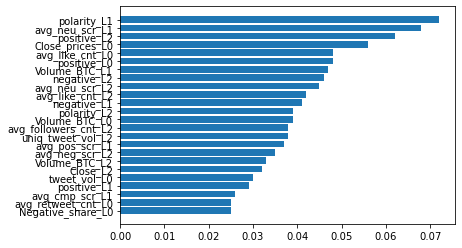

In [43]:
#Feature importance refers to techniques that assign a score to input features based on 
#how useful they are at predicting a target variable.
importances_ML = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rfc.best_estimator_.feature_importances_,3)})
importances_ML = importances_ML.sort_values('importance',ascending=True)
ml = importances_ML.loc[importances_ML['importance'] > 0]
ml.sort_values('importance', inplace=True)
plt.barh(ml['feature'], ml['importance'])

### Random Forest - Hyper parameter tuning using RandomisedSearchCV

In [44]:
rfc = RandomForestClassifier()
rfc.fit(X_train,Y_train.values.ravel())
# predictions
rfc_predict = rfc.predict(X_test)

In [45]:
rfc_cv_score = cross_val_score(rfc, X, y.values.ravel(), cv=10, scoring='roc_auc')

In [46]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(Y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[4 1]
 [2 6]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.67      0.80      0.73         5
         1.0       0.86      0.75      0.80         8

    accuracy                           0.77        13
   macro avg       0.76      0.78      0.76        13
weighted avg       0.78      0.77      0.77        13



=== All AUC Scores ===
[0.25       0.         0.16666667 0.83333333 1.         1.
 1.         0.5        0.5        1.        ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.625


In [47]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators_1 = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features_1 = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators_1,
 'max_features': max_features_1,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, Y_train.values.ravel())
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 140}


In [48]:
rfc = RandomForestClassifier(n_estimators=400, max_depth=140, max_features='sqrt', random_state=0)
rfc.fit(X_train,Y_train.values.ravel())
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y.values.ravel(), cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(Y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[4 1]
 [1 7]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80         5
         1.0       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



=== All AUC Scores ===
[0.16666667 0.33333333 0.16666667 0.66666667 1.         1.
 1.         0.5        0.5        1.        ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6333333333333333


**Results - Random Forest with hyper parameter tuning gave the highest accuracy of 85%**

### 4. Neural Networks

Here, we tried Neural Networks method, which is superior at capturing complex relationships between varibles by searching through different models in its black box to find patterns. In its black box, there can be one or more linear or non-linear hidden layers. 

We need to normalise the data before running neural networks as it is sensitive to feature scaling. We also specify that it will train using 2 hidden layers as 1 or 2 should give a decent performance for most problems, and 20 as number of neurons as we have 20 features in our dataset. 

In [49]:
scaler = StandardScaler()
NN_Xtrain = scaler.fit_transform(X_train)
NN_Xtest = scaler.transform(X_test)

params = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
model = MLPClassifier(hidden_layer_sizes = (20, 20), max_iter = 100, solver='adam', random_state=0) 
#2 hidden layers and 'adam' optimizer works well for large dataset
mlp = GridSearchCV(model, param_grid = params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
mlp.fit(NN_Xtrain, Y_train.values.ravel())
print(mlp.best_estimator_) 

MLPClassifier(alpha=10, hidden_layer_sizes=(20, 20), max_iter=100,
              random_state=0)


C:\Users\saggarwal\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



In [50]:
y_preds = mlp.predict(NN_Xtest)
print(classification_report(Y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(Y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.67      0.40      0.50         5
         1.0       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13

(2, 3, 1, 7) 



**Kindly note the model explanations and implementation is referred from the work done in Digital Marketing Module for assignment 3 and entire project is used as a learning for this analysis**